In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [8]:
def preprocess_inputs(df):

    df = df.copy()
   

    # Drop Route
    df = df.drop(['Route'], axis=1)
    
    # Extract Days and Months from Date of journey
    df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
    df['Day of Journey'] = df['Date_of_Journey'].dt.day
    df['Month of Journey'] = df['Date_of_Journey'].dt.month
    df = df.drop('Date_of_Journey', axis=1)
   
    
    # Convert and encode departure and arrival time to 4 different times of the day (morning, noon, afternoon, evening)
    df['Dep_Time'] = pd.to_datetime(df['Dep_Time']).dt.hour/6
    df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time']).dt.hour/6
    
    # Duration converting to minutes
    df['H'] = df['Duration'].str.extract(r'(\d*(?=h))')
    df['M'] = df['Duration'].str.extract(r'(\d*(?=m))')
    df[['H', 'M']] = df[['H', 'M']].fillna(0)
    df[['H', 'M']] = df[['H', 'M']].astype(int)
    df['Duration'] = df['H'] * 60 + df['M']
    df = df.drop(['H', 'M'], axis=1)
    


    # Features from Additional info and total stops 
    
    df['Total_Stops']=df['Total_Stops'].map({'non-stop':0 ,'1 stop':1 ,'2 stops':2,'3 stops':3,'4 stops':4})
    df['Meal'] = df['Additional_Info'].map({'In-flight meal not included':1, 'No info':0})
    df['Baggage'] = df['Additional_Info'].map({'No check-in baggage included':1,'No info':0 })
    df = df.drop('Additional_Info', axis=1)
    
    
    # Source, Destination and Airline encoding (One-hot)
    df = pd.concat([df, pd.get_dummies(df['Source'], prefix='S')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['Destination'], prefix='D')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['Airline'])], axis=1)
    df = df.drop(['Source', 'Destination','Airline'], axis=1)
   
    df = df.fillna(0) #to avoid null values 
    
    
    
   
    # Split X and y
    X = df.drop(['Price'], axis=1)
    y = np.log(df['Price'])
    X_scaled = (X -np.min(X))/(np.max(X)-np.min(X))
    y_scaled = (y -np.min(y))/(np.max(y)-np.min(y))

    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, train_size=0.8, shuffle = True, random_state = 0)
    """
    #exploratory data analysis
    corr = df.corr() #to see the correlation between each feature and the price 
    plt.figure(figsize=(12,10))
    sns.heatmap(corr.corr(),cmap = 'coolwarm', annot=False)
    """
    
    return X_train, X_test, y_train, y_test




In [4]:
data = pd.read_excel('Data_Train.xlsx')

/Users/macbookair/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '24/03/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/macbookair/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '24/06/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/macbookair/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '27/05/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/macbookair/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '18/04/

      Dep_Time  Arrival_Time  Duration  Total_Stops  Day of Journey  \
508   0.869565      0.782609  0.471103         0.25        0.750000   
3071  0.260870      0.608696  0.162872         0.25        0.875000   
2036  0.956522      0.434783  0.241681         0.25        0.000000   
49    1.000000      0.826087  0.416813         0.50        1.000000   
9686  0.956522      0.000000  0.052539         0.00        1.000000   
...        ...           ...       ...          ...             ...   
9225  0.260870      0.173913  0.464098         0.25        0.125000   
4859  0.956522      0.826087  0.444834         0.50        0.125000   
3264  0.347826      0.173913  0.427320         0.25        0.000000   
9845  0.478261      0.521739  0.525394         0.25        0.625000   
2732  0.869565      1.000000  0.569177         0.25        0.083333   

      Month of Journey  Meal  Baggage  S_Banglore  S_Chennai  ...  GoAir  \
508           0.363636   0.0      0.0         0.0        0.0  ...    0.

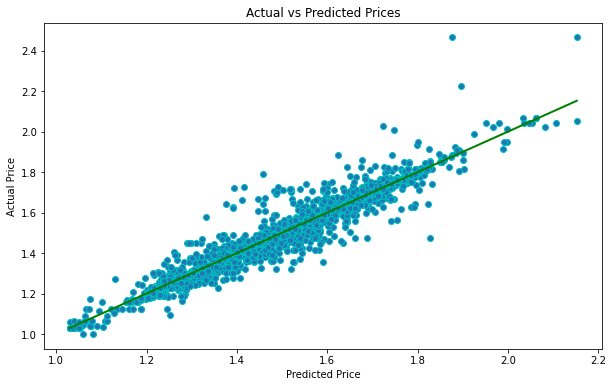

Linear : R2 Score = 0.7334
                   RMSE = 0
                    MAE = 0
                   MAPE = 4.98 %



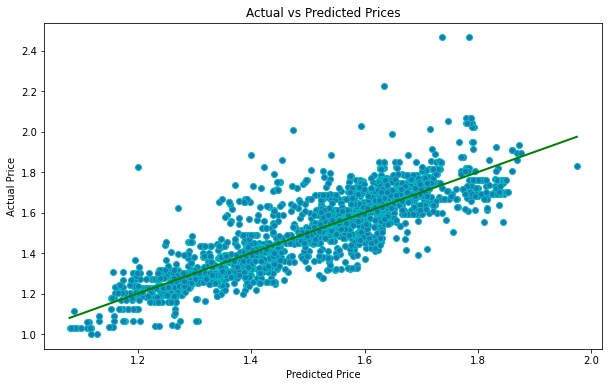

In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

print(X_train)

print("-------- Training --------")
list1=[RandomForestRegressor(), LinearRegression()]
for i in list1:
    i.fit(X_train, y_train)

print("Random forest trained!")
print("Linear trained!")
print("---------- Done ----------")

y_test = np.exp(y_test)

for i in list1:
    y_pred = np.exp(i.predict(X_test))
    if i == list1[0]:
        print("Random Forest : R2 Score = {:.4f}".format(r2_score(y_test, y_pred)))
        print("                   RMSE = {:.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
        print("                    MAE = {:.0f}".format(mean_absolute_error(y_test, y_pred)))
        print("                   MAPE = {:.2f} %\n".format(mean_absolute_percentage_error(y_test, y_pred) * 100))
    else:
        print("Linear : R2 Score = {:.4f}".format(r2_score(y_test, y_pred)))
        print("                   RMSE = {:.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
        print("                    MAE = {:.0f}".format(mean_absolute_error(y_test, y_pred)))
        print("                   MAPE = {:.2f} %\n".format(mean_absolute_percentage_error(y_test, y_pred) * 100))        
       

    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, y_test, edgecolor='c')
    plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], c='g', lw=2)
    plt.title("Actual vs Predicted Prices")
    plt.xlabel("Predicted Price")
    plt.ylabel("Actual Price")
    plt.show()


    
    